In [14]:
import numpy as np
import pandas as pd

# Model Selection
from sklearn.model_selection import train_test_split

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Datasets
from sklearn.datasets import load_breast_cancer

# Warnings
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

In [3]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (569, 30)
y shape: (569,)


In [4]:
# y is a series so i convert it to data frame
y = pd.DataFrame(data=y, columns=['target'])

In [5]:
# Split the dataset into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Print the shapes of the datasets
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (341, 30) (341, 1)
Validation set: (114, 30) (114, 1)
Test set: (114, 30) (114, 1)


### Train Models and get Probabilities

In [6]:
model_to_clf = {
    'rf': RandomForestClassifier,
    'lgr': LogisticRegression,
    'svc': SVC,
    'nb': GaussianNB
               }

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.linear_model._logistic.LogisticRegression'>
<class 'sklearn.svm._classes.SVC'>
<class 'sklearn.naive_bayes.GaussianNB'>


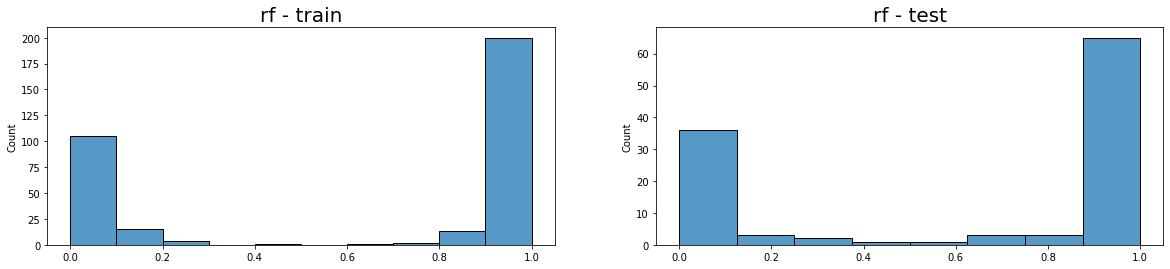

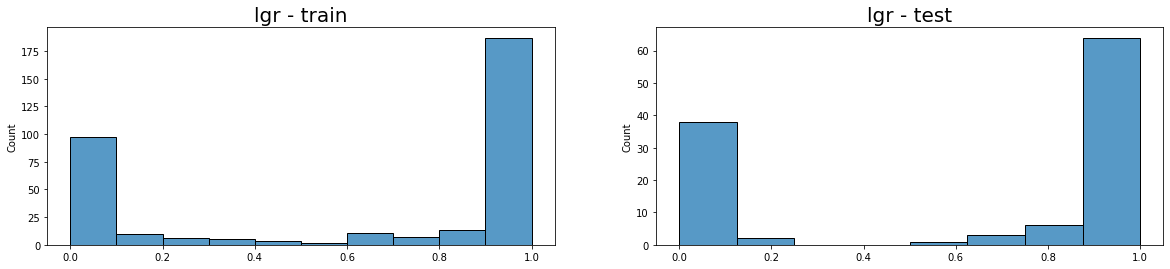

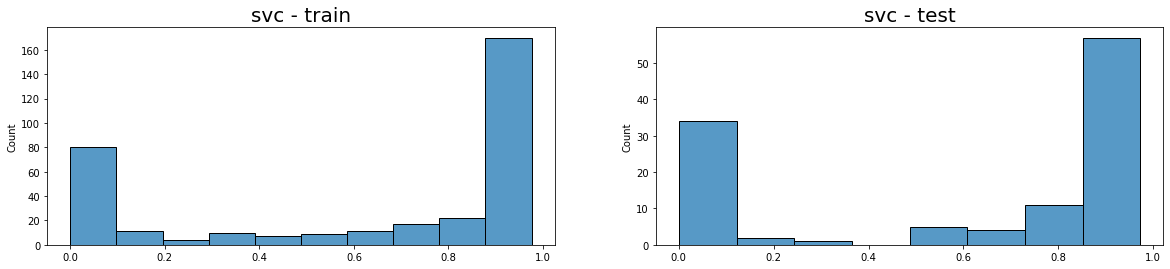

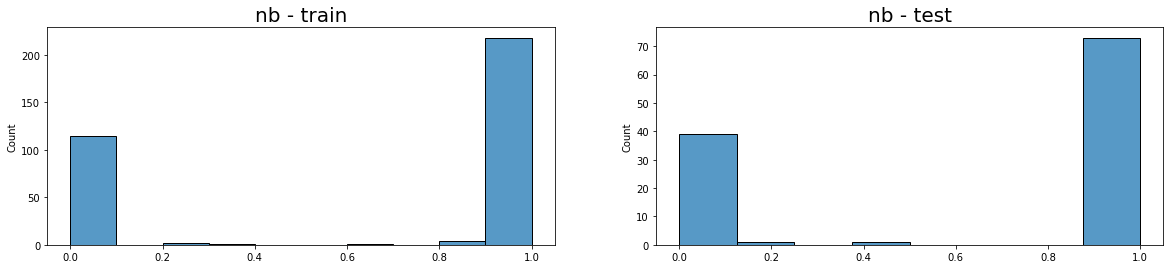

In [9]:
model_to_probs = {}
model_str_to_trained_model = {}

for model_str, model in model_to_clf.items():
    print(model)
    if model == SVC:
        clf = model(probability=True)
    elif model == LogisticRegression:
        clf = model(solver='liblinear')
    else:
        clf = model()
        
    clf.fit(X_train, y_train.squeeze())
    
    pred_probs_train = clf.predict_proba(X_train)[:,1]
    pred_probs_test = clf.predict_proba(X_test)[:,1]
    pred_probs_valid = clf.predict_proba(X_val)[:,1]
    
    model_to_probs[model_str] = {'train': pred_probs_train, 'test': pred_probs_test, 'valid': pred_probs_valid}
    
    plt.figure(figsize=(20,4))
    
    plt.subplot(1,2,1)
    sns.histplot(pred_probs_train)
    plt.title(f"{model_str} - train", fontsize=20)
    
    plt.subplot(1,2,2)
    sns.histplot(pred_probs_test)
    plt.title(f"{model_str} - test", fontsize=20)
    
    model_str_to_trained_model[model_str] = clf

### Plot Predicted Values vs. Empirical Values

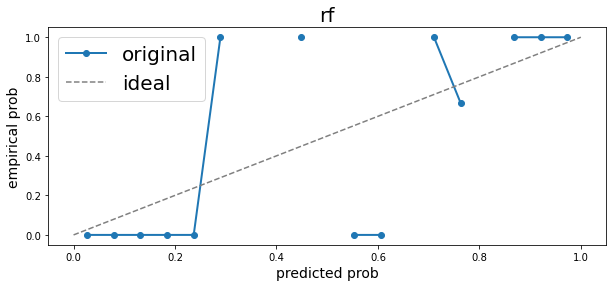

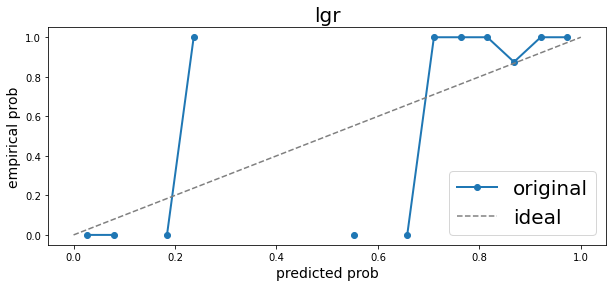

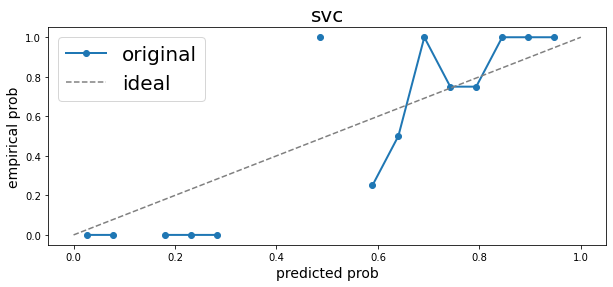

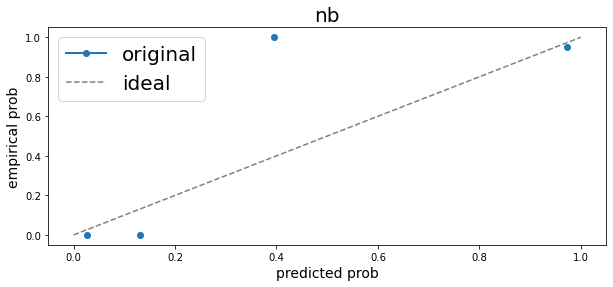

In [17]:
for model_str, pred_prob_dict in model_to_probs.items():
    pred_probs = pred_prob_dict['test']

    pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 20)

    empirical_probs = []
    pred_probs_midpoints = []

    for i in range(len(pred_probs_space)-1):
        empirical_probs.append(np.mean(y_test[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]))
        pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)

    plt.figure(figsize=(10,4))
    plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
    plt.title(f"{model_str}", fontsize=20)
    plt.xlabel('predicted prob', fontsize=14)
    plt.ylabel('empirical prob', fontsize=14)
    
    plt.plot([0,1],[0,1],linestyle='--',color='gray')
    
    plt.legend(['original', 'ideal'], fontsize=20)

### Calibrate

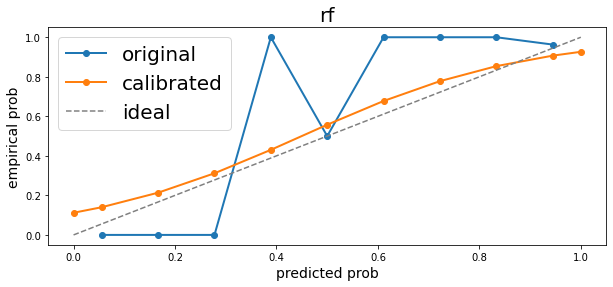

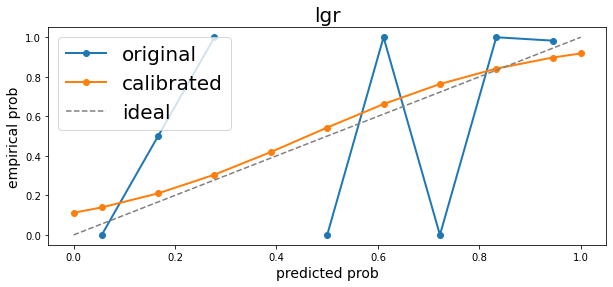

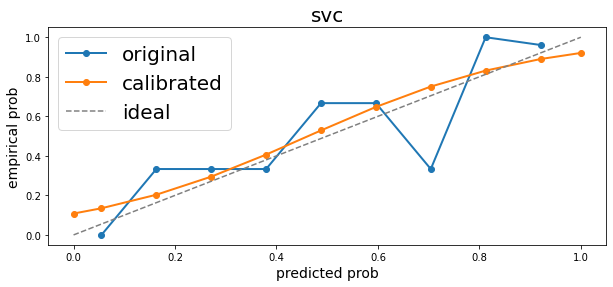

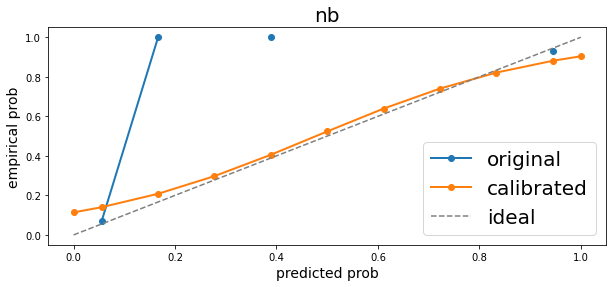

In [16]:
model_str_to_calibrator = {}

for model_str, pred_prob_dict in model_to_probs.items():
    #train calibration model
    lr_model = LogisticRegression()
    lr_model.fit(pred_prob_dict['test'].reshape(-1,1), y_test)
    
    pred_probs = pred_prob_dict['valid']

    pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 10)

    empirical_probs = []
    pred_probs_midpoints = []

    for i in range(len(pred_probs_space)-1):
        empirical_probs.append(np.mean(y_val[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]))
        pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)

    calibrated_probs = lr_model.predict_proba(np.array([0.0]+pred_probs_midpoints+[1.0]).reshape(-1,1))[:,1]
    
    plt.figure(figsize=(10,4))
    plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
    plt.title(f"{model_str}", fontsize=20)
    plt.xlabel('predicted prob', fontsize=14)
    plt.ylabel('empirical prob', fontsize=14)
    
    plt.plot([0.0]+pred_probs_midpoints+[1.0], calibrated_probs, linewidth=2, marker='o')
    
    plt.plot([0,1],[0,1],linestyle='--',color='gray')
    
    plt.legend(['original', 'calibrated', 'ideal'], fontsize=20)
    
    model_str_to_calibrator[model_str] = lr_model